# Análisis de la Base de Datos de Vulnerabilidades

Este notebook está dedicado al análisis de una base de datos que contiene información sobre vulnerabilidades extraídas de la API CVE de NIST. La base de datos se ha construido para organizar mejor la información obtenida de las consultas a la API, permitiendo un análisis más estructurado y eficiente.

## Contexto

La base de datos se compone de varias tablas relacionadas que almacenan diferentes aspectos de las vulnerabilidades. A continuación, se presenta la estructura de la base de datos y sus tablas.

### Estructura de la Base de Datos

#### Tabla cve_data

| Columna           | Tipo de Dato    |
|-------------------|-----------------|
| id                | VARCHAR(50)     |
| sourceIdentifier  | VARCHAR(255)    |
| published         | DATETIME        |
| lastModified      | DATETIME        |
| vulnStatus        | VARCHAR(50)     |
| description_en    | TEXT            |
| description_es    | TEXT            |
| vendor            | VARCHAR(255)    |

#### Tabla cvss_metrics

| Columna               | Tipo de Dato    |
|-----------------------|-----------------|
| id                    | INT AUTO_INCREMENT |
| cve_id                | VARCHAR(50)     |
| version               | VARCHAR(10)     |
| vectorString          | TEXT            |
| attackVector          | VARCHAR(50)     |
| attackComplexity      | VARCHAR(50)     |
| privilegesRequired    | VARCHAR(50)     |
| userInteraction       | VARCHAR(50)     |
| scope                 | VARCHAR(50)     |
| confidentialityImpact | VARCHAR(50)     |
| integrityImpact       | VARCHAR(50)     |
| availabilityImpact    | VARCHAR(50)     |
| baseScore             | FLOAT           |
| baseSeverity          | VARCHAR(50)     |
| exploitabilityScore   | FLOAT           |
| impactScore           | FLOAT           |

#### Tabla cwe

| Columna | Tipo de Dato    |
|---------|-----------------|
| id      | INT AUTO_INCREMENT |
| cve_id  | VARCHAR(50)     |
| cwe_id  | VARCHAR(50)     |

#### Tabla references

| Columna | Tipo de Dato    |
|---------|-----------------|
| id      | INT AUTO_INCREMENT |
| cve_id  | VARCHAR(50)     |
| url     | TEXT            |
| source  | VARCHAR(255)    |
| tags    | TEXT            |

Cada tabla está diseñada para almacenar diferentes aspectos de las vulnerabilidades, desde la información básica hasta los detalles de las métricas CVSS, las debilidades CWE y las referencias externas. Esta estructura permite una organización eficiente y una fácil consulta de los datos extraídos de la API CVE de NIST.

## Pasos para el Análisis
1. **Conexión a la Base de Datos**: Primero, se establecerá una conexión a la base de datos para poder extraer la información necesaria.

In [6]:
import mysql.connector
import pandas as pd
from Tools.Functions import *



db_config = load_config('./Config/Parameters.json')
db_config = db_config['database']

# Conectar a la base de datos
conn = mysql.connector.connect(**db_config)

Una vez establecida la conexión a la base de datos (conn), se procede a realizar el primer análisis enfocado en la descripción de las vulnerabilidades almacenadas. Para ello, se ejecuta una consulta a la tabla cve_data, que contiene las descripciones de las vulnerabilidades. Posteriormente, se lleva a cabo un análisis de sentimientos en inglés utilizando técnicas de procesamiento de lenguaje natural (NLP) para determinar si el tono general de las descripciones es negativo, neutro o positivo.

El análisis de sentimientos con TextBlob generará un valor de polaridad para cada descripción:

- **Polaridad**: Un valor entre -1.0 (muy negativo) y 1.0 (muy positivo).

Por ejemplo, si el valor de sentiment_en es:

- Cercano a 1.0: El tono de la descripción es positivo.
- Cercano a -1.0: El tono de la descripción es negativo.
- Cercano a 0: El tono es neutro.

In [7]:
query = "SELECT id, description_en FROM cve_data"

# Ejecutar la consulta y cargar los resultados en un DataFrame de pandas
data = pd.read_sql(query, conn)



# Aplicar el análisis de sentimientos a las descripciones en inglés
data['sentiment_en'] = data['description_en'].apply(analyze_sentiment)
sentiment_summary = data['sentiment_en'].describe()
print("Resumen de sentimientos de las descripciones en inglés:")
print(sentiment_summary)
data['sentiment_class'] = data['sentiment_en'].apply(classify_sentiment)
print(data[['id', 'sentiment_en', 'sentiment_class']])

C:\Users\MSI-Sebas\AppData\Local\Temp\ipykernel_6716\3894355837.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Resumen de sentimientos de las descripciones en inglés:
count    1123.000000
mean       -0.003767
std         0.120456
min        -0.500000
25%        -0.066667
50%         0.000000
75%         0.038839
max         0.800000
Name: sentiment_en, dtype: float64
                 id  sentiment_en sentiment_class
0     CVE-2002-0367     -0.041667          Neutra
1     CVE-2004-0210      0.028571          Neutra
2     CVE-2004-1464     -0.050000          Neutra
3     CVE-2005-2773     -0.100000          Neutra
4     CVE-2006-1547     -0.033333          Neutra
...             ...           ...             ...
1118  CVE-2024-4671      0.092000          Neutra
1119  CVE-2024-4761      0.020000          Neutra
1120  CVE-2024-4947     -0.010000          Neutra
1121  CVE-2024-4978      0.000000          Neutra
1122  CVE-2024-5274     -0.010000          Neutra

[1123 rows x 3 columns]


## Resultados del Análisis

### Resumen de sentimientos de las descripciones en inglés:

| Métrica | Valor       |
|---------|-------------|
| count   | 1123.000000 |
| mean    | -0.003767   |
| std     | 0.120456    |
| min     | -0.500000   |
| 25%     | -0.066667   |
| 50%     | 0.000000    |
| 75%     | 0.038839    |
| max     | 0.800000    |

### Interpretación de los Resultados

- **count (1123)**: Indica que se analizaron 1123 descripciones de vulnerabilidades.
- **mean (-0.003767)**: La media de la polaridad es ligeramente negativa, cercana a 0, lo que sugiere que, en promedio, las descripciones tienen un tono neutro.
- **std (0.120456)**: La desviación estándar es 0.120456, lo que indica que hay cierta variabilidad en los sentimientos de las descripciones.
- **min (-0.500000)**: La polaridad mínima es -0.5, lo que indica que la descripción más negativa tiene un tono moderadamente negativo.
- **25% (-0.066667)**: El 25% de las descripciones tienen una polaridad menor o igual a -0.066667, lo que sugiere que una cuarta parte de las descripciones tienen un tono ligeramente negativo.
- **50% (0.000000)**: La mediana es 0, lo que indica que la mitad de las descripciones tienen un tono neutro.
- **75% (0.038839)**: El 75% de las descripciones tienen una polaridad menor o igual a 0.038839, lo que sugiere que la mayoría de las descripciones tienen un tono neutro o ligeramente positivo.
- **max (0.800000)**: La polaridad máxima es 0.8, lo que indica que la descripción más positiva tiene un tono bastante positivo.

### Clasificación de Sentimientos

Además de calcular la polaridad, se clasificaron los sentimientos en categorías (negativo, neutro, positivo) utilizando la función classify_sentiment. Los resultados de esta clasificación se imprimieron junto con los identificadores de las vulnerabilidades (id), la polaridad (sentiment_en) y la clase de sentimiento (sentiment_class).

Este análisis proporciona una visión general del tono de las descripciones de vulnerabilidades, lo que puede ser útil para entender cómo se presentan y perciben las vulnerabilidades en términos de su gravedad y urgencia.

Dado que los resultados están muy cerca del valor neutro (0) y no alcanzan el valor máximo de 1, se puede considerar que los valores más altos son prioritarios en comparación con los valores menores o negativos.

In [8]:
from collections import Counter
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import plotly.graph_objects as go

# Descargar stopwords de NLTK si no las tienes
import nltk
nltk.download('stopwords')

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para contar palabras en las descripciones excluyendo stop words y números
def word_frequency(descriptions):
    words = []
    for desc in descriptions:
        if desc:  # Evitar descripciones nulas
            # Extraer palabras, evitar números y convertir todo a minúsculas
            filtered_words = [word for word in re.findall(r'\w+', desc.lower()) 
                              if word not in stop_words and not word.isdigit()]
            words.extend(filtered_words)
    return Counter(words)

# Analizar frecuencia de palabras en las descripciones en inglés
en_word_freq = word_frequency(data['description_en'])

# Obtener las 10 palabras más comunes
common_words = en_word_freq.most_common(50)

# Mostrar las palabras más comunes
print("Palabras más comunes en descripciones en inglés:")
for word, freq in common_words:
    print(f"{word}: {freq}")

# Extraer palabras y frecuencias para el gráfico
words, frequencies = zip(*common_words)



# Crear gráfico interactivo de barras con Plotly
fig = go.Figure(data=[go.Bar(x=words, y=frequencies, marker_color='skyblue')])

fig.update_layout(
    title='10 Palabras más comunes en las descripciones en inglés',
    xaxis=dict(title='Palabras clave'),
    yaxis=dict(title='Frecuencia'),
    hovermode='x',  # Mostrar leyenda al pasar el puntero por la barra
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

fig.show()




Palabras más comunes en descripciones en inglés:
vulnerability: 973
windows: 635
remote: 622
code: 561
attacker: 528
via: 438
arbitrary: 429
server: 399
allows: 397
execute: 344
crafted: 342
could: 333
issue: 321
versions: 309
x: 300
cve: 288
execution: 287
affected: 282
attackers: 269
allow: 254
microsoft: 240
system: 217
memory: 217
may: 216
exploit: 213
ios: 209
user: 206
aka: 206
access: 205
web: 190
privilege: 187
prior: 185
cisco: 180
exploited: 166
sp2: 165
service: 160
elevation: 157
version: 154
unauthenticated: 153
file: 152
device: 152
privileges: 143
cause: 143
security: 143
sp1: 141
earlier: 136
software: 129
corruption: 122
office: 114
kernel: 111


[nltk_data] Downloading package stopwords to C:\Users\MSI-
[nltk_data]     Sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Métricas CVSS

El Sistema de Puntuación de Vulnerabilidades Común (CVSS) es un marco abierto diseñado para comunicar las características y la gravedad de las vulnerabilidades en el software. CVSS se compone de cuatro grupos de métricas: Base, Amenaza, Ambiental y Suplementaria. Estas métricas son proporcionadas por la API de la NVD (National Vulnerability Database) y se presentan en diferentes versiones, siendo CVSSv2 y CVSSv3.1 las más comunes al trabajar con la API de vulnerabilidades del NIST.

### a. Puntuación de Explotabilidad

Esta métrica evalúa el estado actual de las técnicas de explotación o la disponibilidad del código de explotación. La disponibilidad pública de código de explotación fácil de usar incrementa el número de posibles atacantes, incluyendo aquellos sin habilidades especializadas, lo que aumenta la gravedad de la vulnerabilidad.

Resumen estadístico de Exploitability Score (v3.1 vs v2.0):
count    920.000000
mean       5.137283
std        1.717969
min        0.000000
25%        4.700000
50%        6.100000
75%        6.100000
max        7.900000
Name: difference, dtype: float64




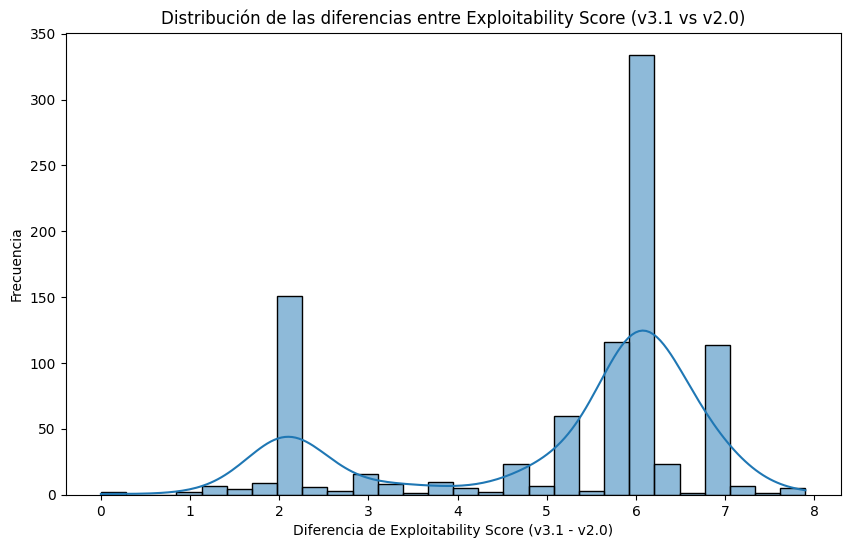

Resumen estadístico de Impact Score (v3.1 vs v2.0):
count    920.000000
mean       2.116413
std        1.977639
min       -3.100000
25%        0.500000
50%        2.400000
75%        4.100000
max        6.400000
Name: difference, dtype: float64




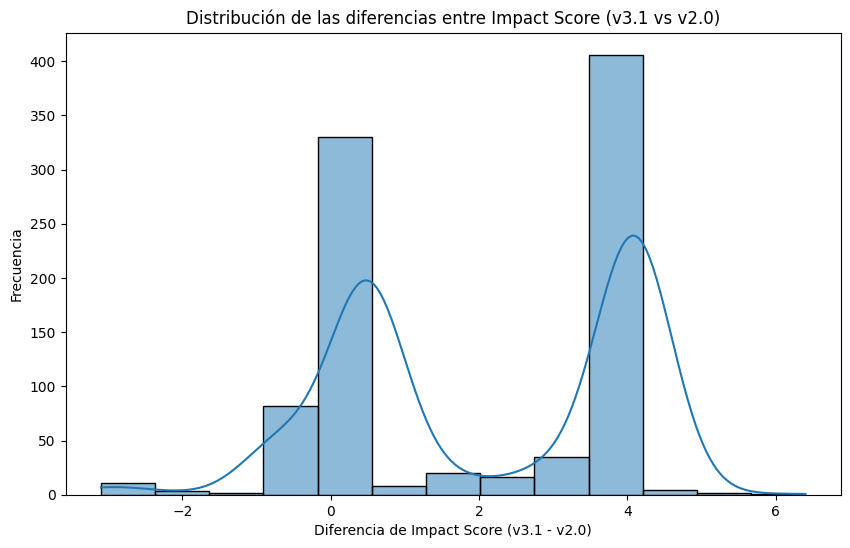

Resumen estadístico de Base Score (v3.1 vs v2.0):
count    920.000000
mean      -1.033804
std        1.511853
min       -5.700000
25%       -2.300000
50%       -0.800000
75%        0.200000
max        3.800000
Name: difference, dtype: float64




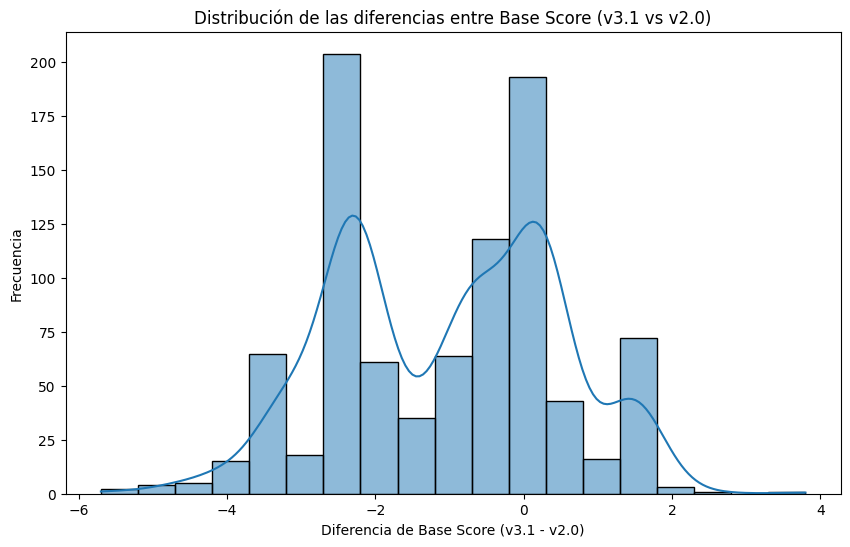

Resumen estadístico de Base Severity (v3.1 vs v2.0):
count    920.000000
mean       1.545978
std        1.577448
min       -3.900000
25%        0.000000
50%        2.000000
75%        3.000000
max        7.000000
Name: difference, dtype: float64




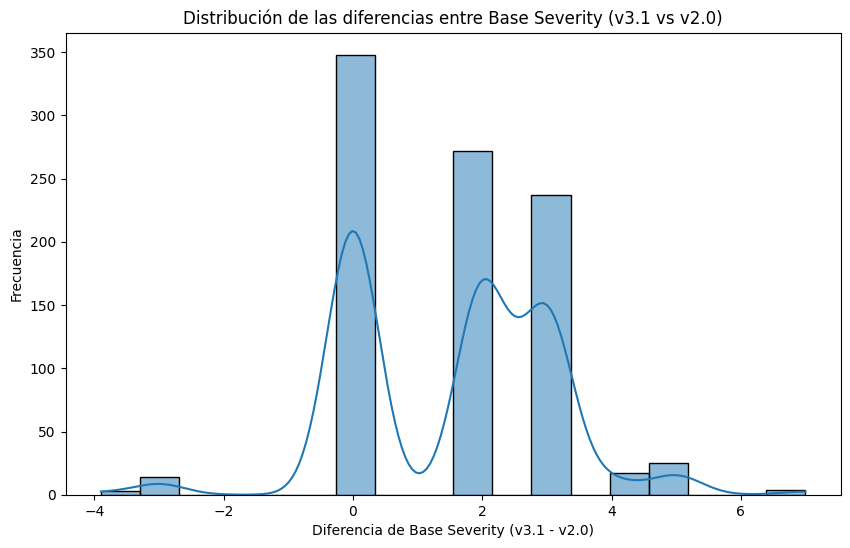

In [9]:
import seaborn as sns

conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

# Consultas para cada tipo de score
queries = {
    'Exploitability Score': """
        SELECT
            cve_data.id AS cve_id,
            cvss_v31.exploitabilityScore AS exploitability_v31,
            cvss_v2.exploitabilityScore AS exploitability_v2
        FROM
            cve_data
        JOIN
            cvss_metrics_v31 AS cvss_v31 ON cve_data.id = cvss_v31.cve_id
        JOIN
            cvss_metrics_v2 AS cvss_v2 ON cve_data.id = cvss_v2.cve_id;
    """,
    'Impact Score': """
        SELECT
            cve_data.id AS cve_id,
            cvss_v31.impactScore AS impact_v31,
            cvss_v2.impactScore AS impact_v2
        FROM
            cve_data
        JOIN
            cvss_metrics_v31 AS cvss_v31 ON cve_data.id = cvss_v31.cve_id
        JOIN
            cvss_metrics_v2 AS cvss_v2 ON cve_data.id = cvss_v2.cve_id;
    """,
    'Base Score': """
        SELECT
            cve_data.id AS cve_id,
            cvss_v31.baseScore AS base_score_v31,
            cvss_v2.baseScore AS base_score_v2
        FROM
            cve_data
        JOIN
            cvss_metrics_v31 AS cvss_v31 ON cve_data.id = cvss_v31.cve_id
        JOIN
            cvss_metrics_v2 AS cvss_v2 ON cve_data.id = cvss_v2.cve_id;
    """,
    'Base Severity': """
        SELECT
            cve_data.id AS cve_id,
            cvss_v31.baseSeverity AS base_severity_v31,
            cvss_v2.baseSeverity AS base_severity_v2
        FROM
            cve_data
        JOIN
            cvss_metrics_v31 AS cvss_v31 ON cve_data.id = cvss_v31.cve_id
        JOIN
            cvss_metrics_v2 AS cvss_v2 ON cve_data.id = cvss_v2.cve_id;
    """
}

# Función para ejecutar consulta y analizar diferencias
def analyze_scores(query, title, severity_map_v2=None, severity_map_v31=None):
    cursor = conn.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [col.split(' AS ')[1].strip() for col in query.split('SELECT')[1].split('FROM')[0].split(',')]

    df = pd.DataFrame(results, columns=columns)
    cursor.close()
    
    if title == 'Base Severity':
        # Verificar si las columnas existen en el DataFrame
        if 'base_severity_v2' in df.columns and 'base_severity_v31' in df.columns:
            # Mapear severidades a puntuaciones numéricas
            severity_map_v2 = {
                'NONE': 0.0,
                'LOW': 0.0,
                'MEDIUM': 4.0,
                'HIGH': 7.0
            }

            severity_map_v31 = {
                'NONE': 0.0,
                'LOW': 0.1,
                'MEDIUM': 4.0,
                'HIGH': 7.0,
                'CRITICAL': 9.0
            }
            df['base_severity_v2'] = df['base_severity_v2'].map(severity_map_v2)
            df['base_severity_v31'] = df['base_severity_v31'].map(severity_map_v31)
            df['difference'] = df['base_severity_v31'] - df['base_severity_v2']
        else:
            print(f"Las columnas 'base_severity_v2' o 'base_severity_v31' no están en el DataFrame para {title}.")
            return
    else:
        # Convertir columnas a float y manejar errores
        df[columns[1]] = pd.to_numeric(df[columns[1]], errors='coerce')
        df[columns[2]] = pd.to_numeric(df[columns[2]], errors='coerce')
        # Calcular diferencias
        df['difference'] = df[columns[2]] - df[columns[1]]
    
    # Imprimir el resumen estadístico de las diferencias
    print(f"Resumen estadístico de {title} (v3.1 vs v2.0):")
    print(df['difference'].describe())
    print("\n")
    
    # Visualizar la distribución de las diferencias
    plt.figure(figsize=(10, 6))
    sns.histplot(df['difference'], kde=True)
    plt.title(f"Distribución de las diferencias entre {title} (v3.1 vs v2.0)")
    plt.xlabel(f"Diferencia de {title} (v3.1 - v2.0)")
    plt.ylabel("Frecuencia")
    plt.show()

# Ejecutar análisis para todos los scores
for title, query in queries.items():
    analyze_scores(query, title)

# Cerrar la conexión
conn.close()

### Calificaciones de CVSS v2.0

| Severidad | Rango de puntuación de gravedad |
|-----------|---------------------------------|
| Ninguno*  | 0.0                             |
| Bajo      | 0.0-3.9                         |
| Medio     | 4.0-6.9                         |
| Alto      | 7.0-10.0                        |

### Calificaciones de CVSS v3.x

| Severidad | Rango de puntuación de gravedad |
|-----------|---------------------------------|
| Ninguno*  | 0.0                             |
| Bajo      | 0.1-3.9                         |
| Medio     | 4.0-6.9                         |
| Alto      | 7.0-8.9                         |
| Crítico   | 9.0-10.0                        |

La gráfica del Exploitability Score presenta dos picos notables en los valores de diferencia de 2 y 6. Esto sugiere que, en muchas vulnerabilidades, la discrepancia entre los exploitability scores de CVSS v3.1 y v2.0 suele rondar entre 2 y 6 puntos. Para el Impact Score, las diferencias se concentran en torno a 0 y 4 puntos. En cuanto al Base Score, las diferencias oscilan entre -3 y 0, siendo este valor negativo posiblemente debido a ajustes en la ponderación de ciertos factores en CVSS v3.1... Por último, en el Base Severity, las diferencias se encuentran entre 0 y 3 puntos, reflejando un ajuste más moderado entre ambas versiones.

Además, la mayoría de los datos están concentrados en el lado positivo del eje X, lo que sugiere que CVSS v2.0 generalmente tiene puntuaciones de explotabilidad, impacto y base severuty más altas que CVSS v3.1. Esto significa que, en general, CVSS v3.1 reduce los enfasis en las metricas en comparación con CVSS v2.0. Esta reducción podría deberse a que CVSS v3.1 toma en cuenta más factores o ajusta los pesos para ciertos atributos en su cálculo.

La gráfica de Base Score muestra dos picos significativos alrededor de los valores -2 y 0, lo que sugiere que existen dos grupos de vulnerabilidades: uno donde el score de CVSS v3.1 es menor que el de v2.0, y otro donde ambos scores son prácticamente iguales. Esto sugiere que, para muchas vulnerabilidades, no hay grandes cambios entre ambas versiones.Además, la gráfica es asimétrica, con una cola hacia la izquierda (diferencias negativas), indicando que, en algunos casos, CVSS v3.1 tiende a asignar scores más bajos que v2.0. Las diferencias negativas más pronunciadas alcanzan valores cercanos a -5, aunque no son muy frecuentes, lo que podría estar relacionado con ajustes en cómo CVSS v3.1 pondera ciertos factores de riesgo comparado con v2.0.

En resumen, las diferencias observadas sugieren un ajuste en la evaluación del riesgo de las vulnerabilidades entre las dos versiones, con CVSS v3.1 mostrando un enfoque más moderado. Las vulnerabilidades con grandes diferencias deberían ser analizadas individualmente para entender qué cambios específicos están afectando sus puntajes.

# Vector String en CVE de NIST

El vectorString en el contexto de CVEs (Common Vulnerabilities and Exposures) se refiere a la representación textual del vector de ataque de una vulnerabilidad según el sistema de puntuación CVSS (Common Vulnerability Scoring System).

## CVSS v2

El vector string en CVSS v2 incluye las siguientes métricas:

- **AV (Access Vector)**: Tipo de acceso necesario
  - Network
  - Local
  - Adjacent Network

- **AC (Access Complexity)**: Complejidad del acceso
  - Low
  - High

- **Au (Authentication)**: Número de autenticaciones necesarias
  - None
  - Single
  - Multiple

- **C (Confidentiality Impact)**: Impacto en la confidencialidad
  - None
  - Partial
  - Complete

- **I (Integrity Impact)**: Impacto en la integridad
  - None
  - Partial
  - Complete

- **A (Availability Impact)**: Impacto en la disponibilidad
  - None
  - Partial
  - Complete

## CVSS v3.1

El vector string en CVSS v3.1 incluye las siguientes métricas:

- **AV (Attack Vector)**: Tipo de acceso necesario
  - Network
  - Adjacent Network
  - Local
  - Physical

- **AC (Attack Complexity)**: Complejidad del ataque
  - Low
  - High

- **PR (Privileges Required)**: Privilegios requeridos
  - None
  - Low
  - High

- **UI (User Interaction)**: Requiere interacción del usuario
  - None
  - Required

- **S (Scope)**: Cambia el alcance
  - Unchanged
  - Changed

- **C (Confidentiality Impact)**: Impacto en la confidencialidad
  - None
  - Low
  - High

- **I (Integrity Impact)**: Impacto en la integridad
  - None
  - Low
  - High

- **A (Availability Impact)**: Impacto en la disponibilidad
  - None
  - Low
  - High

El vector string resume las características clave de una vulnerabilidad de forma compacta, facilitando su evaluación y comparación. A partir de él, se obtienen valores como el CVSS Base Score, el Impact Subscore y el Exploitability Subscore, que ayudan a cuantificar la gravedad y la facilidad de explotación de la vulnerabilidad.

In [10]:
conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

# Define la consulta SQL
query = """
SELECT cve_id, vectorString, baseScore, impactScore, exploitabilityScore
FROM cvss_metrics_v31

LIMIT 3
"""

# Ejecutar la consulta
cursor.execute(query)

# Recuperar los resultados
results = cursor.fetchall()

# Cerrar la conexión
cursor.close()
conn.close()

In [11]:

import math

# Define the weights as constants
WEIGHTS = {
    'AV': {'N': 0.85, 'A': 0.62, 'L': 0.55, 'P': 0.2},
    'AC': {'H': 0.44, 'L': 0.77},
    'PR': {'U': {'N': 0.85, 'L': 0.62, 'H': 0.27}, 'C': {'N': 0.85, 'L': 0.68, 'H': 0.5}},
    'UI': {'N': 0.85, 'R': 0.62},
    'S': {'U': 6.42, 'C': 7.52},
    'CIA': {'N': 0, 'L': 0.22, 'H': 0.56},
    'E': {'X': 1, 'U': 0.91, 'P': 0.94, 'F': 0.97, 'H': 1},
    'RL': {'X': 1, 'O': 0.95, 'T': 0.96, 'W': 0.97, 'U': 1},
    'RC': {'X': 1, 'U': 0.92, 'R': 0.96, 'C': 1},
    'CIAR': {'X': 1, 'L': 0.5, 'M': 1, 'H': 1.5}
}

def parse_vector_string(vector_string):
    """Parse the CVSS vector string into a dictionary of metrics."""
    metrics = {}
    for part in vector_string.split('/'):
        key, value = part.split(':')
        metrics[key] = value
    return metrics

def round_up1(value):
    """Round up to the nearest 0.1"""
    return math.ceil(value * 10) / 10.0

def calculate_cvss_v3_1(vector_string):
    """
    Calculate the CVSS Base Score, Exploitability, and Impact Score based on the given vector string.

    Parameters:
    - vector_string (str): The CVSS vector string.

    Returns:
    - tuple: (Base Score, Exploitability, Impact Score)
    """
    # Parse the vector string
    metrics = parse_vector_string(vector_string)
    
    # Extract the metric weights
    metricWeightAV = WEIGHTS['AV'][metrics['AV']]
    metricWeightAC = WEIGHTS['AC'][metrics['AC']]
    metricWeightPR = WEIGHTS['PR'][metrics['S']][metrics['PR']]
    metricWeightUI = WEIGHTS['UI'][metrics['UI']]
    metricWeightC = WEIGHTS['CIA'][metrics['C']]
    metricWeightI = WEIGHTS['CIA'][metrics['I']]
    metricWeightA = WEIGHTS['CIA'][metrics['A']]
    metricWeightS = WEIGHTS['S'][metrics['S']]
    
    # Calculate Impact Sub-Score (ISS)
    iss = 1 - ((1 - metricWeightC) * (1 - metricWeightI) * (1 - metricWeightA))
    
    # Calculate Impact Score
    if metrics['S'] == 'U':
        impact_score = metricWeightS * iss
    else:
        impact_score = metricWeightS * (iss - 0.029) - 3.25 * math.pow(iss - 0.02, 15)
    
    # Calculate Exploitability
    exploitability = 8.22 * metricWeightAV * metricWeightAC * metricWeightPR * metricWeightUI
    
    # Calculate Base Score
    if impact_score <= 0:
        base_score = 0
    else:
        if metrics['S'] == 'U':
            base_score = round_up1(min((exploitability + impact_score), 10))
        else:
            base_score = round_up1(min(WEIGHTS['CIAR']['H'] * (exploitability + impact_score), 10))
    
    return base_score, exploitability, impact_score



# Process and print the results
for row in results:
    cve_id, vector_string, base_score, impact_score,exploitability_score = row
    # Calculate the values using the vectorString
    calculated_base_score, calculated_exploitability, calculated_impact_score = calculate_cvss_v3_1(vector_string)
    
    # Print results
    print(f"CVE ID: {cve_id}")
    print(f"Vector String: {vector_string}")
    print(f"Base Score (calculated): {calculated_base_score}")
    print(f"Exploitability (calculated): {calculated_exploitability}")
    print(f"Impact Score (calculated): {calculated_impact_score}")
    print(f"Base Score (from database): {base_score}")
    print(f"Exploitability (from database): {exploitability_score}")
    print(f"Impact Score (from database): {impact_score}")

    print()

# Close the connection
cursor.close()
conn.close()



CVE ID: CVE-2021-27104
Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
Base Score (calculated): 9.8
Exploitability (calculated): 3.8870427750000003
Impact Score (calculated): 5.873118720000001
Base Score (from database): 9.8
Exploitability (from database): 3.9
Impact Score (from database): 5.9

CVE ID: CVE-2021-27102
Vector String: CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H
Base Score (calculated): 7.8
Exploitability (calculated): 1.8345765900000002
Impact Score (calculated): 5.873118720000001
Base Score (from database): 7.8
Exploitability (from database): 1.8
Impact Score (from database): 5.9

CVE ID: CVE-2021-27101
Vector String: CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H
Base Score (calculated): 9.8
Exploitability (calculated): 3.8870427750000003
Impact Score (calculated): 5.873118720000001
Base Score (from database): 9.8
Exploitability (from database): 3.9
Impact Score (from database): 5.9



## Conclusión del Análisis

En el análisis del sistema CVSS, el **Vector String** emerge como un componente crucial para el cálculo del **Impact Score**, la **Explotabilidad** y el **Puntaje Base**. Al consolidar las características específicas de una vulnerabilidad en un formato estandarizado, el Vector String permite una evaluación uniforme y objetiva del riesgo asociado.

Esta estandarización facilita la comparación y priorización de vulnerabilidades, proporcionando una base sólida para la toma de decisiones informadas respecto a las medidas de mitigación. La capacidad del Vector String para encapsular diversos factores de riesgo asegura que las evaluaciones sean coherentes y precisas, optimizando así el proceso de gestión de vulnerabilidades y fortaleciendo la seguridad general del sistema.



In [12]:
import plotly.graph_objects as go

# Conectar a la base de datos y recuperar los datos
conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

query = """SELECT cwe.id,
                  cwe.cve_id,
                  cwe.cwe_id
            FROM cwe"""

cursor.execute(query)
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['id', 'cve_id', 'cwe_id'])

# Extraer el año del CVE ID
df['year'] = df['cve_id'].str.extract(r'CVE-(\d{4})').astype(int)

# Contar la cantidad de vulnerabilidades por año y cwe_id
count_df = df.groupby(['year', 'cwe_id']).size().reset_index(name='count')

# Crear la gráfica interactiva con Plotly
fig = go.Figure()

for cwe_id in count_df['cwe_id'].unique():
    subset = count_df[count_df['cwe_id'] == cwe_id]
    fig.add_trace(go.Scatter(
        x=subset['year'],
        y=subset['count'],
        mode='lines+markers',
        name=cwe_id,
        line=dict(smoothing=0.3)  # Suaviza la línea
    ))

# Configurar el diseño de la gráfica
fig.update_layout(
    title='Número de Vulnerabilidades por CWE ID a lo Largo del Tiempo',
    xaxis_title='Año',
    yaxis_title='Cantidad de Vulnerabilidades',
    legend_title='CWE ID',
    template='plotly_white'
)

# Mostrar la gráfica
fig.show()

# Cerrar la conexión
cursor.close()
conn.close()

In [13]:
conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

# Ejecutar la consulta para obtener la relación CWE-CVE
cursor.execute("SELECT cve_id, cwe_id FROM cwe")
cwe_data = cursor.fetchall()
df_cwe = pd.DataFrame(cwe_data, columns=['cve_id', 'cwe_id'])

# Ejecutar la consulta para obtener las métricas de CVSS v3.1
cursor.execute("SELECT cve_id, baseScore, exploitabilityScore, impactScore FROM cvss_metrics_v31")
cvss_metrics_v31_data = cursor.fetchall()
df_v31 = pd.DataFrame(cvss_metrics_v31_data, columns=['cve_id', 'baseScore', 'exploitabilityScore', 'impactScore'])

# Ejecutar la consulta para obtener las métricas de CVSS v2
cursor.execute("SELECT cve_id, baseScore, exploitabilityScore, impactScore FROM cvss_metrics_v2")
cvss_metrics_v2_data = cursor.fetchall()
df_v2 = pd.DataFrame(cvss_metrics_v2_data, columns=['cve_id', 'baseScore', 'exploitabilityScore', 'impactScore'])

# Cerrar la conexión a la base de datos
cursor.close()
conn.close()

# Relación CWE-CVE
df_cwe_cve_relation = df_cwe.groupby('cwe_id').size().reset_index(name='count')

# Top de CWE más repetidos
top_cwe = df_cwe_cve_relation.sort_values(by='count', ascending=False)

# Métricas combinadas CVSS v3.1 y v2
df_combined = df_v31.merge(df_v2, on='cve_id', suffixes=('_v31', '_v2'))

# Relacionar métricas CVE con CWE
df_full = df_cwe.merge(df_combined, on='cve_id')

# Agrupar por CWE y calcular las métricas promedio
cwe_metrics = df_full.groupby('cwe_id').agg({
    'baseScore_v31': 'mean',
    'exploitabilityScore_v31': 'mean',
    'impactScore_v31': 'mean',
    'baseScore_v2': 'mean',
    'exploitabilityScore_v2': 'mean',
    'impactScore_v2': 'mean'
}).reset_index()

# Mostrar resultados: Top CWE y métricas calculadas
print("Top CWE más comunes:")
print(top_cwe)
# Top de CWE por cada métrica
top_baseScore_v31 = cwe_metrics[['cwe_id', 'baseScore_v31']].sort_values(by='baseScore_v31', ascending=False).head(10)
top_exploitabilityScore_v31 = cwe_metrics[['cwe_id', 'exploitabilityScore_v31']].sort_values(by='exploitabilityScore_v31', ascending=False).head(10)
top_impactScore_v31 = cwe_metrics[['cwe_id', 'impactScore_v31']].sort_values(by='impactScore_v31', ascending=False).head(10)

top_baseScore_v2 = cwe_metrics[['cwe_id', 'baseScore_v2']].sort_values(by='baseScore_v2', ascending=False).head(10)
top_exploitabilityScore_v2 = cwe_metrics[['cwe_id', 'exploitabilityScore_v2']].sort_values(by='exploitabilityScore_v2', ascending=False).head(10)
top_impactScore_v2 = cwe_metrics[['cwe_id', 'impactScore_v2']].sort_values(by='impactScore_v2', ascending=False).head(10)

# Mostrar los resultados
print("Top CWE por baseScore v3.1:")
print(top_baseScore_v31)
print("\nTop CWE por exploitabilityScore v3.1:")
print(top_exploitabilityScore_v31)
print("\nTop CWE por impactScore v3.1:")
print(top_impactScore_v31)

print("\nTop CWE por baseScore v2:")
print(top_baseScore_v2)
print("\nTop CWE por exploitabilityScore v2:")
print(top_exploitabilityScore_v2)
print("\nTop CWE por impactScore v2:")
print(top_impactScore_v2)


Top CWE más comunes:
             cwe_id  count
119  NVD-CWE-noinfo    244
99          CWE-787    140
56          CWE-416     85
96           CWE-78     81
18           CWE-20     64
..              ...    ...
85          CWE-697      1
86          CWE-703      1
88           CWE-73      1
28          CWE-280      1
0          CWE-1056      1

[120 rows x 2 columns]
Top CWE por baseScore v3.1:
      cwe_id  baseScore_v31
47   CWE-444          10.00
23   CWE-285           9.90
52   CWE-522           9.85
11   CWE-178           9.80
63   CWE-706           9.80
31   CWE-345           9.80
25   CWE-288           9.80
21   CWE-276           9.80
83    CWE-91           9.80
0   CWE-1056           9.80

Top CWE por exploitabilityScore v3.1:
      cwe_id  exploitabilityScore_v31
0   CWE-1056                      3.9
40   CWE-404                      3.9
25   CWE-288                      3.9
23   CWE-285                      3.9
21   CWE-276                      3.9
31   CWE-345                

In [14]:
import plotly.express as px
import plotly.subplots as sp

# Crear subplots
fig = sp.make_subplots(rows=3, cols=2, subplot_titles=[
    "Top 10 CWE por baseScore (v3.1)", 
    "Top 10 CWE por baseScore (v2.0)", 
    "Top 10 CWE por exploitabilityScore (v3.1)", 
    "Top 10 CWE por exploitabilityScore (v2.0)", 
    "Top 10 CWE por impactScore (v3.1)", 
    "Top 10 CWE por impactScore (v2.0)"
])

# Gráfico de barras para baseScore v3.1
fig_baseScore_v31 = px.bar(top_baseScore_v31.head(10), 
                           x='cwe_id', y='baseScore_v31', 
                           labels={'baseScore_v31': 'Base Score (v3.1)', 'cwe_id': 'CWE ID'},
                           color='baseScore_v31')

# Gráfico de barras para baseScore v2.0
fig_baseScore_v2 = px.bar(top_baseScore_v2.head(10), 
                          x='cwe_id', y='baseScore_v2', 
                          labels={'baseScore_v2': 'Base Score (v2.0)', 'cwe_id': 'CWE ID'},
                          color='baseScore_v2')

# Gráfico de barras para exploitabilityScore v3.1
fig_exploitability_v31 = px.bar(top_exploitabilityScore_v31.head(10), 
                                x='cwe_id', y='exploitabilityScore_v31', 
                                labels={'exploitabilityScore_v31': 'Exploitability (v3.1)', 'cwe_id': 'CWE ID'},
                                color='exploitabilityScore_v31')

# Gráfico de barras para exploitabilityScore v2.0
fig_exploitability_v2 = px.bar(top_exploitabilityScore_v2.head(10), 
                               x='cwe_id', y='exploitabilityScore_v2', 
                               labels={'exploitabilityScore_v2': 'Exploitability (v2.0)', 'cwe_id': 'CWE ID'},
                               color='exploitabilityScore_v2')

# Gráfico de barras para impactScore v3.1
fig_impact_v31 = px.bar(top_impactScore_v31.head(10), 
                        x='cwe_id', y='impactScore_v31', 
                        labels={'impactScore_v31': 'Impact Score (v3.1)', 'cwe_id': 'CWE ID'},
                        color='impactScore_v31')

# Gráfico de barras para impactScore v2.0
fig_impact_v2 = px.bar(top_impactScore_v2.head(10), 
                       x='cwe_id', y='impactScore_v2', 
                       labels={'impactScore_v2': 'Impact Score (v2.0)', 'cwe_id': 'CWE ID'},
                       color='impactScore_v2')

# Añadir gráficos a los subplots
fig.add_traces(fig_baseScore_v31['data'], rows=1, cols=1)
fig.add_traces(fig_baseScore_v2['data'], rows=1, cols=2)
fig.add_traces(fig_exploitability_v31['data'], rows=2, cols=1)
fig.add_traces(fig_exploitability_v2['data'], rows=2, cols=2)
fig.add_traces(fig_impact_v31['data'], rows=3, cols=1)
fig.add_traces(fig_impact_v2['data'], rows=3, cols=2)

# Ajustes finales
fig.update_layout(height=1000, width=1200, title_text="Subplots de Métricas CVSS v3.1 y v2.0 por CWE")
fig.update_xaxes(categoryorder='total descending')

fig.show()


In [15]:
import plotly.figure_factory as ff

# Crear una tabla de correlación
corr = df_full[['baseScore_v31', 'exploitabilityScore_v31', 'impactScore_v31', 'baseScore_v2', 'exploitabilityScore_v2', 'impactScore_v2']].corr()

# Crear el heatmap
fig = ff.create_annotated_heatmap(
    z=corr.values, 
    x=list(corr.columns), 
    y=list(corr.columns), 
    annotation_text=corr.round(2).values,
    colorscale='Viridis'
)

fig.update_layout(title_text='Correlación entre Métricas CVSS v3.1 y v2', height=500)
fig.show()


In [16]:
# Scatterplot interactivo para v3.1
fig = px.scatter(df_full, 
                 x='exploitabilityScore_v31', y='impactScore_v31', 
                 color='cwe_id', 
                 title='Exploitability Score vs Impact Score (v3.1)',
                 labels={'exploitabilityScore_v31': 'Exploitability Score (v3.1)', 'impactScore_v31': 'Impact Score (v3.1)'},
                 height=600)

fig.update_traces(marker=dict(size=12))
fig.show()
